In [54]:
import numpy as np
import pandas as pd
import json
from dateutil.parser import parse
import time
from datetime import datetime

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

from collections import Counter

from mpl_toolkits import mplot3d

import spacy
# loading language model
nlp = spacy.load('en_core_web_sm')

import demoji

import re

#visualization
import seaborn as sns 
%matplotlib inline 
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
plt.style.use('seaborn-whitegrid')
sns.set(color_codes=True)

from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score

import warnings
warnings.filterwarnings('ignore')


# Loading Json and train data files

In [4]:
# opening sentiment score from Jason file for train data
with open('train_data-1573118738755.json') as f:
    sentiment=json.load(f)
pre_sentiment = pd.DataFrame.from_dict(sentiment)
pre_sentiment['records'].str.replace('"','')

# opening sentiment score from Jason file for test data
with open('test_data.json') as f:
    sentiment_test=json.load(f)
pre_sentiment_test = pd.DataFrame.from_dict(sentiment_test)
pre_sentiment_test['records'].str.replace('"','')

#Dataframe at this point is a dictionary
#     Train data
objs = [pre_sentiment, pd.DataFrame(pre_sentiment['records'].tolist())]
sentiment_df = pd.concat(objs, axis=1).drop('records', axis=1)
#     Test data
objs_test = [pre_sentiment_test, pd.DataFrame(pre_sentiment_test['records'].tolist())]
sentiment_dft = pd.concat(objs_test, axis=1).drop('records', axis=1)

# Sentiment data is converted into a dataframe with 4 columns 
#     Train data
sentiment_df['timestamp'] = pd.to_datetime(sentiment_df['timestamp'])
sentiment_df.timestamp.apply(str)
sentiment_df.timestamp.apply(lambda x: x.date())
#     Test data
sentiment_dft['timestamp'] = pd.to_datetime(sentiment_dft['timestamp'])
sentiment_dft.timestamp.apply(str)
sentiment_dft.timestamp.apply(lambda x: x.date())

print("Size of train score: ",sentiment_df.shape)
print("Size of test score: ",sentiment_dft.shape)

Size of train score:  (1039131, 4)
Size of test score:  (265022, 3)


In [7]:
# Reading train Data
train_data1 = pd.read_csv("train_factors-1573207730757.csv",header=0)

train_data1['date'] = pd.to_datetime(train_data1['date']) # converts object to date time format
train_data1.date.apply(str)

# Reading test data
test_data1 = pd.read_csv("test_factors.csv",header=0)

test_data1['date'] = pd.to_datetime(test_data1['date']) # converts object to date time format
test_data1.date.apply(str)

print("Size of train data: ",train_data1.shape)
print("Size of test data: ",test_data1.shape)

Size of train data:  (27006, 11)
Size of test data:  (11575, 10)


In [8]:
# print("\n==============================\nSentiment Train Data\n==============================\n",sentiment_df.head())
# print("------------------------------\n",sentiment_df.dtypes)
# print("------------------------------\nunique tickers in Jason file: \n",np.size(sentiment_df['ticker'].unique()))
# print("------------------------------\nunique sentiment_score: ",np.size(sentiment_df['sentiment_score'].unique()))
# print(sentiment_df['sentiment_score'].unique())
# print("------------------------------\n",sum(sentiment_df.isna().sum())," Null Values")
# print("Start date for Sentiment score:",min(sentiment_df['timestamp']))
# print("End date for Sentiment score:",max(sentiment_df['timestamp']))


# print("\n==============================\nTrain Data\n==============================\n",train_data1.head())
# print("------------------------------\n",train_data1.dtypes)
# print("------------------------------\nunique alpha: ",np.size(train_data1['alpha'].unique()))
# print(train_data1['alpha'].unique())
# print("------------------------------\n",sum(train_data1.isna().sum())," Null Values")
# print("Start date for Sentiment score:",min(train_data1['date']))
# print("End date for Sentiment score:",max(train_data1['date']))

In [16]:
sentiment_df.dtypes

stocktwit_tweet    object
sentiment_score     int64
date               object
ticker             object
dtype: object

# Analysis Before Preprocessing
- No Null values 
- 4 categories of alpha [1,2,3,4]
- 5 categories of sentiment score [0,1,2,3,4]
- Need to convert columns between Json and train dat into common format for merging
- Categorize the alpha and sentiment score and compare the relationship i.e. validity of crowd wisdom to assess the future predictions
- Visualize and perform feature engineering to bring together similar features from train data contributing to alpha signal


# Pre-Processing
- Changing the column names for the sentiment data to match with train data

In [9]:
sentiment_df.columns = ['stocktwit_tweet', 'sentiment_score', 'date', 'ticker']
sentiment_dft.columns = ['stocktwit_tweet', 'date', 'ticker']

- Timestamp conversion into a common format "dd-mm-yyyy" for both sentiment and the train data

In [10]:
date_vec_senti=sentiment_df['date']
date_vec_train=train_data1['date']

date_vec_senti_test=sentiment_dft['date']
date_vec_test=test_data1['date']

def dateconverter(x):
    datestr=x.strftime("%d %b %Y")
    x_new= datetime.strptime(datestr, '%d %b %Y').strftime('%d-%m-%Y')
    return x_new

def dateconverter2(x):
    datestr=x.strftime("%Y %b %d")
    x_new= datetime.strptime(datestr, '%Y %b %d').strftime('%d-%m-%Y')
    return x_new

date_vec_senti = date_vec_senti.apply(lambda x:dateconverter(x))
date_vec_train = date_vec_train.apply(lambda x:dateconverter2(x))

date_vec_senti_test = date_vec_senti_test.apply(lambda x:dateconverter(x))
date_vec_test = date_vec_test.apply(lambda x:dateconverter2(x))

sentiment_df['date']=date_vec_senti
train_data1['date']=date_vec_train
sentiment_df['date']=date_vec_senti
train_data1['date']=date_vec_train

- Dropping Unique IDs from train data

In [11]:
train_data1 = train_data1.drop(["Id"], axis=1)
test_data1 = test_data1.drop(["Id"], axis=1)

- Converting tickers into a common format by stripping '$' and converting into upper case

In [12]:
sentiment_df['ticker']=sentiment_df['ticker'].str.replace('$','')
sentiment_df['ticker']=sentiment_df['ticker'].str.upper()
train_data1['ticker']=train_data1['ticker'].str.replace('$','')
train_data1['ticker']=train_data1['ticker'].str.upper()

sentiment_dft['ticker']=sentiment_dft['ticker'].str.replace('$','')
sentiment_dft['ticker']=sentiment_dft['ticker'].str.upper()
test_data1['ticker']=test_data1['ticker'].str.replace('$','')
test_data1['ticker']=test_data1['ticker'].str.upper()

- Cleaning Tweets

- Finding mean values for sentiment score based on dates and tickers
- This will compress the essence of the sentiments extracted from the tweets

In [21]:
# senti_mode=sentiment_df.groupby(['date','ticker'], as_index=False)['sentiment_score'].apply(lambda x: x.mode())
senti_mean=sentiment_df.groupby(['date','ticker'], as_index=False)['sentiment_score'].mean()
senti_mean['sentiment_score']=senti_mean['sentiment_score'].astype(int)
senti_mean.round(0)

# print(senti_mode.shape)
# print(senti_mode.head())
# print(senti_mode.dtypes)

print(senti_mean.shape)
print(senti_mean.head())
print(senti_mean.dtypes)

(57606, 3)
         date ticker  sentiment_score
0  01-07-2018   AABA                2
1  01-07-2018    AAL                2
2  01-07-2018    AAP                1
3  01-07-2018   AAPL                2
4  01-07-2018   ABBV                1
date               object
ticker             object
sentiment_score     int32
dtype: object


- Adding average sentiment scores to train data based on tickers and dates 

In [22]:
alpha_senti_score = pd.merge(train_data1, senti_mean, on=['date', 'ticker'],how='left')

# Verifying new Train Data comparing train data

print("size train data with average sentiment score:", alpha_senti_score.shape)
print("train data",train_data1.shape)
print(alpha_senti_score.isna().sum(axis=0))
# print(alpha_senti_score.describe())
print("------------------------------\nunique sentiment scores: \n",np.size(alpha_senti_score['sentiment_score'].unique()))
print(alpha_senti_score['sentiment_score'].unique())

size train data with average sentiment score: (27006, 11)
train data (27006, 10)
date                  0
ticker                0
SF1                   0
SF2                   0
SF3                   0
SF4                   0
SF5                   0
SF6                   0
SF7                   0
alpha                 0
sentiment_score    8830
dtype: int64
------------------------------
unique sentiment scores: 
 6
[ 2. nan  1.  0.  3.  4.]


- Imputing null values for sentiment scoreto be 2 median of the scale 0 to 4, meaning the public sentiment is neither positive nor a negative opinion on the stock

In [23]:
alpha_senti_score["sentiment_score"].fillna("2", inplace = True)
alpha_senti_score["sentiment_score"]=alpha_senti_score["sentiment_score"].astype(np.int64)
alpha_senti_score.dtypes


date                object
ticker              object
SF1                float64
SF2                float64
SF3                float64
SF4                float64
SF5                float64
SF6                float64
SF7                float64
alpha                int64
sentiment_score      int64
dtype: object

# Processed Data

In [26]:
print("==============================\nProcessed Train Data\n==============================")
print("Train Data size:",alpha_senti_score.shape)
print("------------------------------\nNo Null Values\n------------------------------\n",alpha_senti_score.isna().sum())
print("------------------------------\nColumn types:\n------------------------------\n",alpha_senti_score.dtypes)
print("------------------------------\nSummary\n------------------------------\n",alpha_senti_score.describe())
print("------------------------------\n",np.size(alpha_senti_score['ticker'].unique()),"Unique Tickers ")
print("------------------------------\n",np.size(alpha_senti_score['alpha'].unique()), " Unique alpha scores",alpha_senti_score['alpha'].unique())
print("------------------------------\n",np.size(alpha_senti_score['sentiment_score'].unique()),"Unique Tickers ",alpha_senti_score['sentiment_score'].unique())


Processed Train Data
Train Data size: (27006, 11)
------------------------------
No Null Values
------------------------------
 date               0
ticker             0
SF1                0
SF2                0
SF3                0
SF4                0
SF5                0
SF6                0
SF7                0
alpha              0
sentiment_score    0
dtype: int64
------------------------------
Column types:
------------------------------
 date                object
ticker              object
SF1                float64
SF2                float64
SF3                float64
SF4                float64
SF5                float64
SF6                float64
SF7                float64
alpha                int64
sentiment_score      int64
dtype: object
------------------------------
Summary
------------------------------
                 SF1           SF2           SF3           SF4           SF5  \
count  27006.000000  27006.000000  27006.000000  27006.000000  27006.000000   
mean       

# Visualization

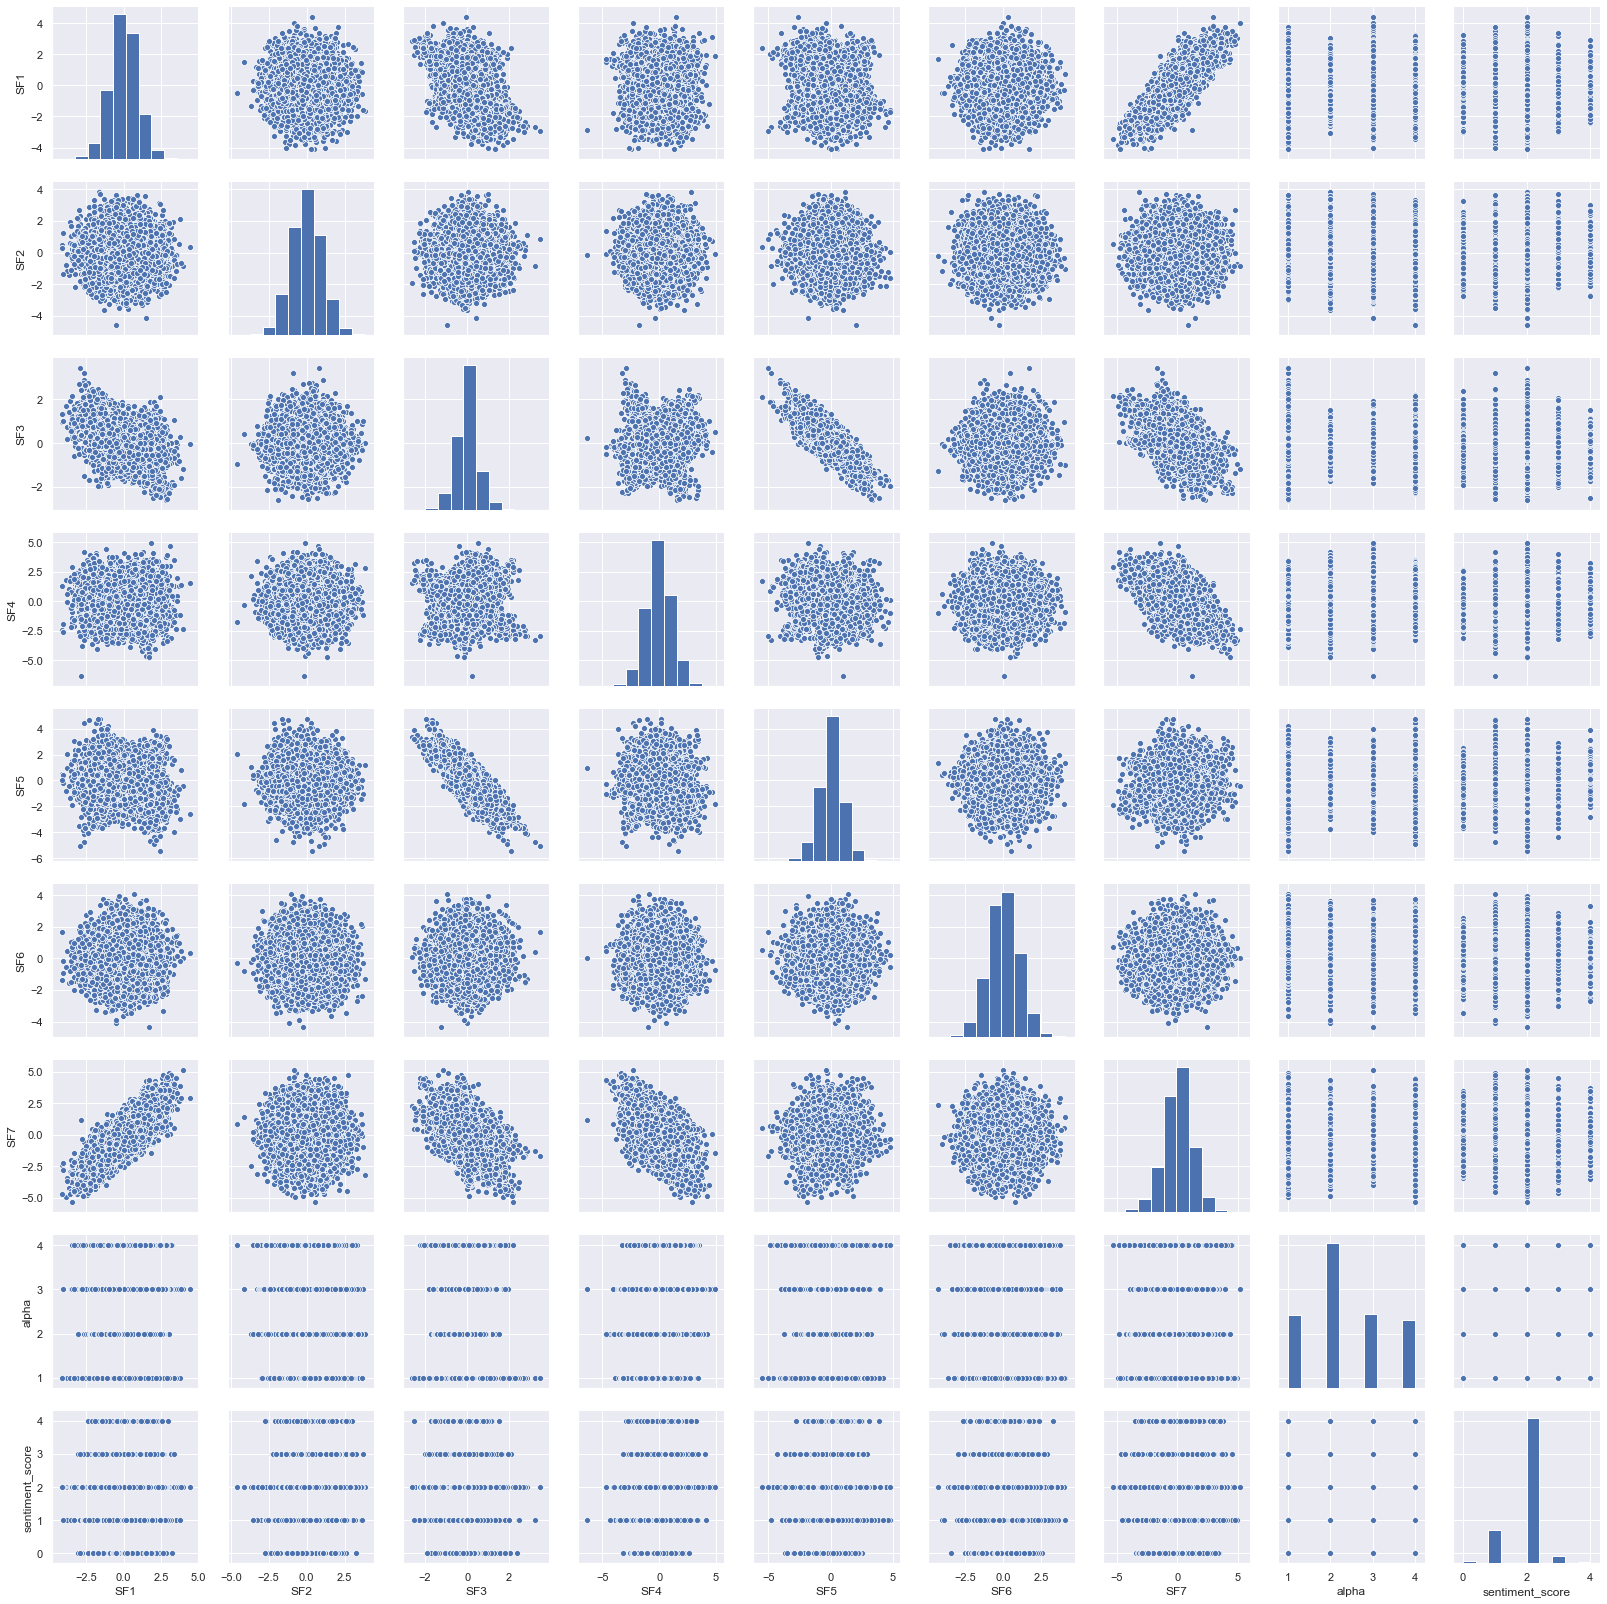

In [28]:
sns.pairplot(alpha_senti_score)

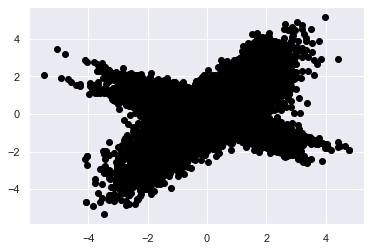

In [29]:
plt.plot(alpha_senti_score['SF1'], alpha_senti_score['SF7'], 'o', color='black');
plt.plot(alpha_senti_score['SF5'], alpha_senti_score['SF3'], 'o', color='black');


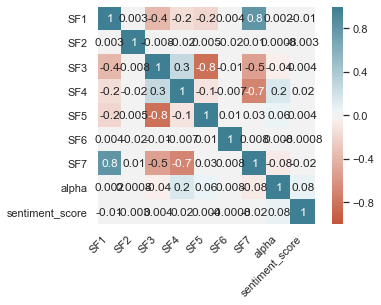

In [30]:
corr = alpha_senti_score.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True,
    fmt='.1g'
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [31]:
alpha_senti_score.corr()['alpha'].sort_values()

SF7               -0.077634
SF3               -0.044415
SF2                0.000762
SF1                0.002482
SF6                0.008481
SF5                0.057072
sentiment_score    0.077779
SF4                0.153574
alpha              1.000000
Name: alpha, dtype: float64

### Insights
- From the list of correlations with individual factors and alpha, SF1, SF2 and SF6 are contributing very less to alpha which can be combined for feature reduction
- Sentiment scores can be used as another factor along with other features (or) to re-weight the factors while tuning the model

# Feature Reduction

In [62]:
alpha_senti_score.dtypes

date                object
ticker              object
SF1                float64
SF2                float64
SF3                float64
SF4                float64
SF5                float64
SF6                float64
SF7                float64
alpha                int64
sentiment_score      int64
dtype: object

In [38]:
# One-hot encoding
# test = alpha_senti_score
# test = pd.get_dummies(test['sentiment_score'])
# test.head()

In [69]:
x = alpha_senti_score.drop(['date','ticker','alpha'],axis=1)
x = x.astype(np.int64)
y = alpha_senti_score['alpha']
y = y.astype(np.int64)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.20)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(21604, 8)
(21604,)
(5402, 8)
(5402,)


In [70]:
scaler = StandardScaler()
scaler.fit(x_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [71]:
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)

In [72]:
stats.describe(x_train)
stats.describe(x_test)

DescribeResult(nobs=5402, minmax=(array([-6.29374243, -5.86488386, -6.89935743, -4.99660824, -5.88932052,
       -4.39086768, -4.50729722, -3.48959495]), array([6.27788532, 4.38976294, 6.90095439, 5.04845161, 5.85412388,
       5.8464346 , 4.48907876, 4.06822052])), mean=array([-0.02712809,  0.0052194 ,  0.01740382, -0.00034386, -0.01243529,
        0.00114995, -0.01285633,  0.04657288]), variance=array([0.99912264, 0.97975423, 1.07520699, 0.9915165 , 0.99060809,
       1.00226776, 0.98666425, 1.0409627 ]), skewness=array([-0.18843924,  0.04199784,  0.292973  ,  0.09066843, -0.21813811,
       -0.00051645, -0.25790508, -0.20178699]), kurtosis=array([ 3.74617005,  2.45127822, 13.50193821,  2.54123985,  4.77401115,
        2.50418477,  2.80466713,  3.69640272]))

In [73]:
model= KNeighborsClassifier(algorithm = 'brute',n_neighbors=5,metric="euclidean")
model.fit(x_train,y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [74]:
y_pred = model.predict(x_test)

MemoryError: Unable to allocate array with shape (5402, 21604) and data type float64

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

In [ ]:
myList = list(range(1,50))

In [ ]:
cv_scores = []

In [ ]:
for k in myList:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

In [ ]:
MCE = [1 - x for x in cv_scores]

In [ ]:
type(MCE)

In [ ]:
optimal_k = myList[MCE.index(min(MCE))]
print("The optimal number of neighbors is %d" % optimal_k)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(myList, MCE)
plt.xticks(np.arange(1, 50, 1))
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

# ML - Model Building

In [ ]:
y=bank["PersonalLoan"]
X=bank.drop('PersonalLoan', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)